<a href="https://colab.research.google.com/github/PreetamMT/COMP9517_Final_Assignment_Code/blob/main/Hybrid_SVM_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

→ using data_dir = /kaggle/input/skyview-an-aerial-landscape-dataset/Aerial_Landscapes
Classes: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']
Train Size: 9600, Test Size: 2400


BoVW Test: 100%|██████████| 2400/2400 [00:02<00:00, 981.61it/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Color hist - Test: 100%|██████████| 2400/2400 [00:14<00:00, 167.13it/s]


Fused features shape (Train/Test): (9600, 352) (2400, 352)
Balanced train size:   9600
Imbalanced train size: 4450

Balanced Accuracy = 0.95875 (train+eval 11.3s)
Imbalanced Accuracy = 0.9008333333333334 (train+eval 4.0s)

>>> Balanced Dataset Report:
              precision    recall  f1-score   support

 Agriculture       0.98      0.98      0.98       160
     Airport       0.91      0.96      0.93       160
       Beach       0.96      0.98      0.97       160
        City       0.97      0.97      0.97       160
      Desert       0.98      0.99      0.98       160
      Forest       0.96      0.97      0.97       160
   Grassland       0.96      0.94      0.95       160
     Highway       0.93      0.96      0.94       160
        Lake       0.94      0.89      0.92       160
    Mountain       0.97      0.97      0.97       160
     Parking       0.98      0.97      0.97       160
        Port       0.97      0.97      0.97       160
     Railway       0.97      0.93      0.95  

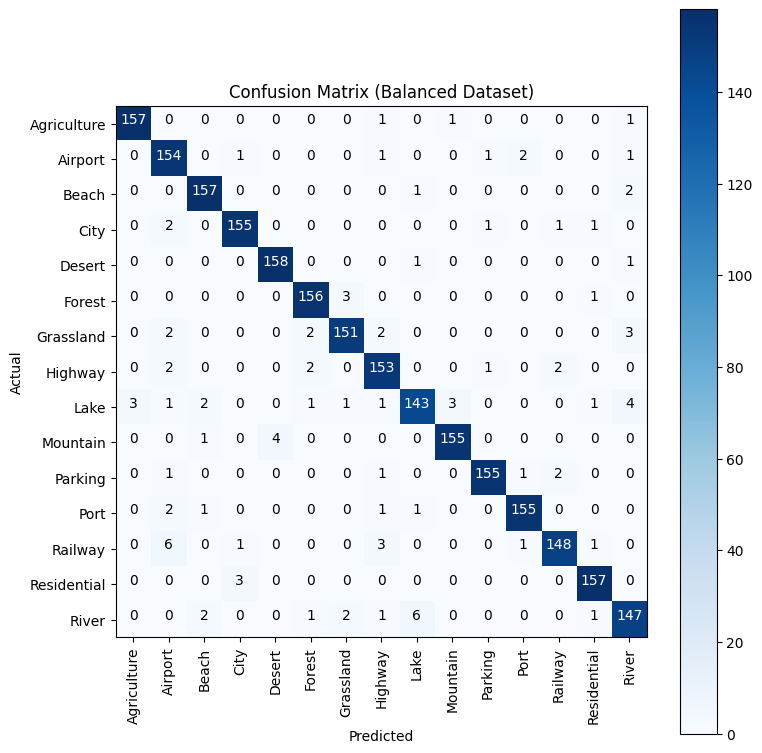

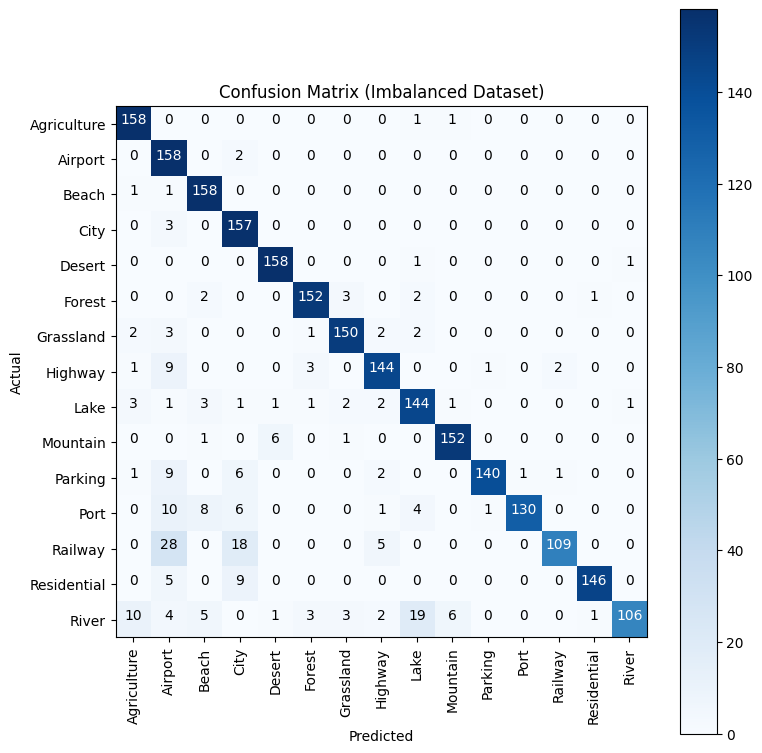

In [ ]:
"""
Hybrid SVM Classification on Aerial Landscapes with Imbalanced Data Simulation
-------------------------------------------------------------------------------

Author:     Charisa Mao Jia Lau
Date:       2025-04-23
Course:     COMP9517 Computer Vision, UNSW
Description:
    This script downloads the SkyView aerial landscape dataset from Kaggle, extracts
    three complementary feature sets (SIFT→BoVW, SENet-50 embeddings + PCA, and HSV
    color histograms), fuses them, and trains an RBF-SVM classifier under two regimes:
      1) Balanced training set (standard 80/20 split)
      2) Simulated long-tail imbalanced training set (head/mid/tail distribution)
    It then prints classification reports and plots confusion matrices for both.

Dependencies:
    - Python 3.7+
    - OpenCV (opencv-contrib-python)
    - scikit-learn
    - matplotlib
    - tqdm
    - kaggle
    - timm
    - torch, torchvision
    - Pillow (PIL)
    - kagglehub (for dataset download abstraction)

Usage:
    1) Install requirements:
        pip install opencv-contrib-python scikit-learn matplotlib tqdm kaggle timm torch torchvision pillow kagglehub
    2) Run:
        python hybrid_svm_imbalanced.py

"""

import os
import cv2
import gc
import random
import time
import logging

import numpy as np
import torch
import timm
import kagglehub
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from torchvision import transforms
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------------------------------------------
# Configuration & Globals
# ------------------------------------------------------------------------------
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)
random.seed(42)  # for reproducible down-sampling below

# ------------------------------------------------------------------------------
# 1) Download & unzip the SkyView dataset into a local folder via kagglehub
# ------------------------------------------------------------------------------
base_path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
data_dir  = os.path.join(base_path, "Aerial_Landscapes")
print("→ using data_dir =", data_dir)

# ------------------------------------------------------------------------------
# 2) Build file-list & labels
# ------------------------------------------------------------------------------
classes, paths, labels = sorted(os.listdir(data_dir)), [], []
for ci, cls in enumerate(classes):
    cls_folder = os.path.join(data_dir, cls)
    for fn in os.listdir(cls_folder):
        paths.append(os.path.join(cls_folder, fn))
        labels.append(ci)
print("Classes:", classes)

# ------------------------------------------------------------------------------
# 3) Train/test split (80/20 stratified)
# ------------------------------------------------------------------------------
train_paths, test_paths, y_train, y_test = train_test_split(
    paths, labels, test_size=0.2, stratify=labels, random_state=42
)
print(f"Train Size: {len(train_paths)}, Test Size: {len(test_paths)}")

# ------------------------------------------------------------------------------
# 4) Extract SIFT descriptors for BoVW
# ------------------------------------------------------------------------------
def extract_sift(paths, desc_label):
    """Extract SIFT keypoint descriptors for each image in paths."""
    sift = cv2.SIFT_create()
    descs = []
    for img_path in tqdm(paths, desc=desc_label):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        _, d = sift.detectAndCompute(img, None)
        descs.append(d if d is not None else np.zeros((1,128), np.float32))
    return descs

train_descs = extract_sift(train_paths, "SIFT - Train")
test_descs  = extract_sift(test_paths,  "SIFT - Test")

# ------------------------------------------------------------------------------
# 5) Build Bag-of-Visual-Words (BoVW) codebook & histograms
# ------------------------------------------------------------------------------
K = 200
all_desc = np.vstack(train_descs)
sample_idx = np.random.choice(all_desc.shape[0], min(100_000, all_desc.shape[0]), replace=False)

kmeans = MiniBatchKMeans(n_clusters=K, batch_size=K*20, random_state=42)
kmeans.fit(all_desc[sample_idx])
del all_desc; gc.collect()

def bovw_hist(descs):
    """Compute L2-normalized BoVW histogram for a set of SIFT descriptors."""
    h = np.bincount(kmeans.predict(descs), minlength=K).astype(float)
    return h / (np.linalg.norm(h) + 1e-6)

X_train_bovw = np.vstack([bovw_hist(d) for d in tqdm(train_descs, desc="BoVW Train")])
X_test_bovw  = np.vstack([bovw_hist(d) for d in tqdm(test_descs,  desc="BoVW Test")])

# ------------------------------------------------------------------------------
# 6) Extract SENet-50 deep embeddings and reduce to 128 via PCA
# ------------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senet = timm.create_model('seresnet50', pretrained=True, num_classes=0).to(device).eval()
prep  = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def extract_senet(paths, desc_label):
    """Extract 2048-dim SENet-50 features, to be PCA-reduced later."""
    feats = []
    with torch.no_grad():
        for img_path in tqdm(paths, desc=desc_label):
            img = Image.open(img_path).convert("RGB")
            t   = prep(img).unsqueeze(0).to(device)
            feats.append(senet(t).view(-1).cpu().numpy())
    return np.vstack(feats)

X_train_senet = extract_senet(train_paths, "SENet50 - Train")
X_test_senet  = extract_senet(test_paths,  "SENet50 - Test")

pca = PCA(n_components=128, random_state=42)
X_train_senet = pca.fit_transform(X_train_senet)
X_test_senet  = pca.transform(X_test_senet)

# ------------------------------------------------------------------------------
# 7) Compute simple HSV color histograms (8 bins × 3 channels → 24 dims)
# ------------------------------------------------------------------------------
def color_hist(path, bins=8):
    """Compute normalized HSV histogram features."""
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2HSV)
    feats = []
    for chn in cv2.split(img):
        h,_ = np.histogram(chn, bins=bins, range=(0,256))
        feats.append(h.astype(float)/(h.sum()+1e-6))
    return np.hstack(feats)

X_train_col = np.vstack([color_hist(p) for p in tqdm(train_paths, desc="Color hist - Train")])
X_test_col  = np.vstack([color_hist(p) for p in tqdm(test_paths,  desc="Color hist - Test")])

# ------------------------------------------------------------------------------
# 8) Fuse all three feature sets
# ------------------------------------------------------------------------------
X_train = np.hstack([X_train_bovw, X_train_senet, X_train_col])
X_test  = np.hstack([X_test_bovw,  X_test_senet,  X_test_col ])
print("Fused features shape (Train/Test):", X_train.shape, X_test.shape)

# ------------------------------------------------------------------------------
# 9) Simulate a long-tail imbalanced training set
# ------------------------------------------------------------------------------
desired = {
    **{c:640 for c in range(0,5)},    # head classes
    **{c:200 for c in range(5,10)},   # mid-frequency classes
    **{c: 50 for c in range(10,15)}   # tail classes
}

cls_to_idxs = defaultdict(list)
for idx, cls in enumerate(y_train):
    cls_to_idxs[cls].append(idx)

keep_idxs = []
for cls, idxs in cls_to_idxs.items():
    n = min(desired.get(cls, len(idxs)), len(idxs))
    keep_idxs += random.sample(idxs, n)

X_train_imb = X_train[keep_idxs]
y_train_imb = [y_train[i] for i in keep_idxs]

print(f"Balanced train size:   {len(y_train)}")
print(f"Imbalanced train size: {len(y_train_imb)}\n")

# ------------------------------------------------------------------------------
# 10) Train & evaluate an RBF-SVM on both balanced and imbalanced sets
# ------------------------------------------------------------------------------
svc = SVC(C=12, gamma=0.04, kernel='rbf', random_state=42)

# — Balanced training —
t0 = time.time()
svc.fit(X_train, y_train)
y_pred_b = svc.predict(X_test)
acc_b    = svc.score(X_test, y_test)
print("Balanced Accuracy =", acc_b, f"(train+eval {time.time()-t0:.1f}s)")

# — Imbalanced training —
t1 = time.time()
svc.fit(X_train_imb, y_train_imb)
y_pred_i = svc.predict(X_test)
acc_i    = svc.score(X_test, y_test)
print("Imbalanced Accuracy =", acc_i, f"(train+eval {time.time()-t1:.1f}s)\n")

# ------------------------------------------------------------------------------
# 11) Print classification reports
# ------------------------------------------------------------------------------
print(">>> Balanced Dataset Report:")
print(classification_report(y_test, y_pred_b, target_names=classes))
print(">>> Imbalanced Dataset Report:")
print(classification_report(y_test, y_pred_i, target_names=classes))

# ------------------------------------------------------------------------------
# 12) Plot confusion matrices
# ------------------------------------------------------------------------------
for cm, title in zip(
    [confusion_matrix(y_test, y_pred_b), confusion_matrix(y_test, y_pred_i)],
    ["Balanced Dataset", "Imbalanced Dataset"]
):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title(f"Confusion Matrix ({title})")
    plt.colorbar()
    plt.xticks(range(len(classes)), classes, rotation=90)
    plt.yticks(range(len(classes)), classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, cm[i,j], ha='center',
                     color='white' if cm[i,j]>cm.max()/2 else 'black')
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()